In [12]:
import scipy, cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from matplotlib.patches import ConnectionPatch
def rgb_to_gray(img):
    if len(img.shape) == 3:
        gray_image = np.mean(img, axis=2).astype(np.float64)
    else:
        gray_image = img
    return gray_image
def gaussian_blur_kernel_2d(kernel_size=3,sigma=1):
    kernel=np.zeros((kernel_size,kernel_size))
    r = kernel_size//2
    for x in range(-r,r+1):
        for y in range(-r,r+1):
            kernel[x+r,y+r] = 1/(2*np.pi*sigma**2)*np.exp(-1/(2*sigma**2)*(x**2+y**2))
    kernel = kernel / np.sum(kernel)
    return kernel
def convolve_2d(X,K):
    height,width = K.shape
    X = np.flip(np.flip(X, axis=0), axis=1)
    Y = np.zeros((X.shape[0]-height+1,X.shape[1]-width+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i][j]=(X[i:i+height, j:j+height]*K).sum()
    return np.flip(np.flip(Y, axis=0), axis=1)
def gradient_x(img):
    # convert img to grayscale
    # should we use int type to calclate gradient?
    # should we conduct some pre-processing to remove noise? which kernel should we pply?
    # which kernel should we choose to calculate gradient_x?
    # TODO
    gray_image = rgb_to_gray(img)
    filtered_image = scipy.ndimage.gaussian_filter(gray_image, sigma = 1, mode = 'reflect')
    return scipy.ndimage.sobel(filtered_image, axis = 0, mode = 'reflect')

def gradient_y(img):
    # TODO
    gray_image = rgb_to_gray(img)
    filtered_image = scipy.ndimage.gaussian_filter(gray_image, sigma = 1, mode = 'reflect')
    return scipy.ndimage.sobel(filtered_image, axis = 1, mode = 'reflect')

def harris_response(img, alpha=0.05, win_size=3):
    # In this function you are going to claculate harris response R.
    # Please refer to 04_Feature_Detection.pdf page 29 for details. 
    # You have to discover how to calculate det(M) and trace(M), and
    # remember to smooth the gradients. 
    # Avoid using too much "for" loops to speed up.
    # TODO
    
    win_size = win_size // 2
    grad_x = gradient_x(img)
    grad_y = gradient_y(img)
    sigma = win_size / 7
    kernel = gaussian_blur_kernel_2d(win_size, sigma)
    A = grad_x * grad_x
    B = grad_x * grad_y
    C = grad_y * grad_y
    R = np.zeros_like(A)
    for i in range(win_size, img.shape[0] - win_size):
        for j in range(win_size, img.shape[1] - win_size):
            windows_A = np.sum(A[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1] * kernel)
            windows_B = np.sum(B[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1] * kernel)
            windows_C = np.sum(C[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1] * kernel)
            det_R = windows_A * windows_C - windows_B * windows_B
            tr_R = windows_A + windows_C
            windows_R = det_R - alpha * tr_R**2
            R[i, j] = windows_R
    return R

def corner_selection(R, th=0.01, min_dist=3):
    # non-maximal suppression for R to get R_selection and transform selected corners to list of tuples
    # hint: 
    #   use ndimage.maximum_filter()  to achieve non-maximum suppression
    #   set those which aren’t **local maximum** to zero.
    # TODO
    width, height = R.shape
    threshold = th * np.max(R)
    condition_matrix = (R > threshold).astype(np.uint8)
    pix = []
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if condition_matrix[i, j]:
                window = R[np.clip(i-min_dist//2,0,width-1):np.clip(i+min_dist//2,0,width-1), np.clip(j-min_dist//2,0,height-1):np.clip(j+min_dist//2,0,height-1)]
                if R[i,j]-1e-6<np.max(window) < R[i,j] + 1e-6:
                    pix.append((i,j))
    return list(pix)
def histogram_of_gradients(img, pix):
    # no template for coding, please implement by yourself.
    # You can refer to implementations on Github or other websites
    # Hint: 
    #   1. grad_x & grad_y
    #   2. grad_dir by arctan function
    #   3. for each interest point, choose m*m blocks with each consists of m*m pixels
    #   4. I divide the region into n directions (maybe 8).
    #   5. For each blocks, calculate the number of derivatives in those directions and normalize the Histogram. 
    #   6. After that, select the prominent gradient and take it as principle orientation.
    #   7. Then rotate it’s neighbor to fit principle orientation and calculate the histogram again. 
    # TODO
    WIDTH,HEIGHT = img.shape
    block_size = 4  
    num_bins = 8 
    grad_x = gradient_x(img)
    grad_y = gradient_y(img)
    grad_magnitude = np.sqrt(grad_x**2,grad_y**2)
    grad_direction = np.arctan2(grad_y,grad_x)*180.0/np.pi + 180.0
    features = []
    for cornel in pix:
        cornel_x, cornel_y = cornel
        temp_feature = [0 for i in range(num_bins)]
        for i in range(cornel_x - block_size**2//2 + 1, cornel_x + block_size**2//2 + 1):
            for j in range(cornel_y - block_size**2//2 + 1, cornel_y + block_size**2//2 + 1):
                    temp_angle = int(grad_direction[np.clip(i,0,WIDTH-1),np.clip(j,0,HEIGHT-1)]*num_bins/360)
                    if temp_angle == num_bins:
                        temp_angle = num_bins - 1
                    temp_feature[temp_angle]+=grad_magnitude[np.clip(i,0,WIDTH-1),int(np.clip(j,0,HEIGHT-1))]
        orientation = np.argmax(temp_feature)*360/num_bins
        feature = []
        for index_x in range(-block_size//2,block_size//2):
            for index_y in range(-block_size//2,block_size//2):
                temp_feature = [0 for i in range(num_bins)]
                for i in range(cornel_x + index_x * block_size + 1, cornel_x + (index_x + 1) * block_size + 1):
                    for j in range(cornel_y + index_y * block_size + 1, cornel_y + (index_y + 1) * block_size + 1):
                        temp_angle = grad_direction[np.clip(i,0,WIDTH-1),np.clip(j,0,HEIGHT-1)] - orientation
                        if temp_angle<0:
                             temp_angle+=360
                        temp_angle = int(temp_angle*num_bins/360)
                        if temp_angle == num_bins:
                            temp_angle = num_bins - 1
                        temp_feature[temp_angle]+=grad_magnitude[np.clip(i,0,WIDTH-1),np.clip(j,0,HEIGHT-1)]
                feature+=temp_feature
        # 归一化
        feature = feature / np.sum(feature)
        features.append(feature)
    return features
def compute_homography(pixels_1, pixels_2):
    # compute the best-fit homography using the Singular Value Decomposition (SVD)
    # homography matrix is a (3,3) matrix consisting rotation, translation and projection information.
    # consider how to form matrix A for U, S, V = np.linalg.svd((np.transpose(A)).dot(A))
    # homo_matrix = np.reshape(V[np.argmin(S)], (3, 3))
    # TODO
    A = []
    for p1, p2 in zip(pixels_1, pixels_2):
        x1, y1 = p1
        x2, y2 = p2
        A.append([x1, y1, 1, 0, 0, 0, -x1 * x2, -y1 * x2, -x2])
        A.append([0, 0, 0, x1, y1, 1, -x1 * y2, -y1 * y2, -y2])
    A = np.array(A)
    # 使用SVD分解
    U, S, V = np.linalg.svd((np.transpose(A)).dot(A))
    homo_matrix = np.reshape(V[np.argmin(S)], (3, 3))
    return homo_matrix
def match_visualizer(image,image_2,pix_1,pix_2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Image 1')
    # 在第二个子图上显示第二幅图像
    ax2.imshow(image_2, cmap='gray')
    ax2.set_title('Image 2')
    for i in range(len(pix_1)):
        ax1.plot(pix_1[i][1],pix_1[i][0],'ro',markersize=1,color='red')
        ax2.plot(pix_2[i][1],pix_2[i][0],'ro',markersize=1,color='red')
        con = ConnectionPatch(xyA=(pix_1[i][1],pix_1[i][0]), xyB=(pix_2[i][1],pix_2[i][0]), linewidth=0.1, axesA= ax1,axesB=ax2,coordsA='data',
                        coordsB='data',color="red")
        ax2.add_artist(con)
    plt.show()
def align_pair(pixels_1, pixels_2):
    # utilize \verb|homo_coordinates| for homogeneous pixels
    # and \verb|compute_homography| to calulate homo_matrix
    # implement RANSAC to compute the optimal alignment.
    # you can refer to implementations online.
    num_iterations = 2000 # Number of RANSAC iterations
    inlier_threshold = 5.0  # Threshold for considering a point as an inlier
    num_picked = 4
    best_inliers = []  # Best set of inliers
    best_est_homo = None  # Best estimated homography matrix
    for _ in range(num_iterations):
        sample_indices = sample(range(len(pixels_1)), num_picked)
        sampled_pixels_1 = [pixels_1[i] for i in sample_indices]
        sampled_pixels_2 = [pixels_2[i] for i in sample_indices]
        est_homo = compute_homography(sampled_pixels_1, sampled_pixels_2)
        homo_coordinates_1 = np.array([pixels_1[i] + tuple([1]) for i in range(len(pixels_1))])
        transformed_pixels = np.dot(est_homo, homo_coordinates_1.T).T
        transformed_pixels = transformed_pixels[:, :2] / transformed_pixels[:, 2, None]+1e-6
        distances = np.linalg.norm(transformed_pixels - pixels_2, axis=1)
        inliers = np.where(distances < inlier_threshold)[0]
        if len(inliers) > len(best_inliers):
            print(len(inliers))
            best_inliers = inliers
            best_est_homo = est_homo
    return best_est_homo
def stitch_blend(img_1, img_2, est_homo):
    # hint: 
    # First, project four corner pixels with estimated homo-matrix
    # and converting them back to Cartesian coordinates after normalization.
    # Together with four corner pixels of the other image, we can get the size of new image plane.
    # Then, remap both image to new image plane and blend two images using Alpha Blending.
    # TODO
    # 先确定画布的大小，先算img1的四个角，把他弄到正的区域，然后算两幅图的起始位置
    WIDTH_1,HEIGHT_1 = img_1.shape[:-1]
    WIDTH_2,HEIGHT_2 = img_2.shape[:-1]
    ALPHA = 0.5
    homo_inverse = np.linalg.inv(est_homo)
    corners = [(0,0,1),(WIDTH_1-1,0,1),(0,HEIGHT_1-1,1),(WIDTH_1-1,HEIGHT_1-1,1)]
    startx_1,starty_1,endx_1,endy_1=float('inf'),float('inf'),-float('inf'),-float('inf')
    for corner in corners:
        modified_corner = est_homo@corner
        modified_corner = modified_corner/modified_corner[2]
        startx_1 = int(min(startx_1,modified_corner[0]))
        endx_1 = int(max(endx_1,modified_corner[0]))
        starty_1 = int(min(starty_1,modified_corner[1]))
        endy_1 = int(max(endy_1,modified_corner[1]))
    startx_2,starty_2,endx_2,endy_2=0,0,WIDTH_2,HEIGHT_2
    if startx_1<0: #平移图像
        startx_2-=startx_1
        endx_2-=startx_1
    else:
        startx_1=0
    if starty_1<0: #平移图像 
        starty_2-=starty_1
        endy_2-=starty_1
    else:
        starty_1=0
    EST_WIDTH = max(endx_1,endx_2)+1
    EST_HEIGHT = max(endy_1,endy_2)+1
    est_img = np.zeros((EST_WIDTH,EST_HEIGHT,3))
    # 写一个函数来确定点是否在重合的区域中，逆矩阵
    def is_inside(point):
        modified_point = homo_inverse@point
        modified_point = modified_point / modified_point[2]
        return (0<modified_point[0]<WIDTH_1 and 0<modified_point[1]<HEIGHT_1),modified_point
    # 先画img2
    for i in range(WIDTH_2):
        for j in range(HEIGHT_2):
            x,y=startx_2+i,starty_2+j
            if is_inside([x+startx_1,y+starty_1,1])[0]:
                est_img[x,y] = img_2[i,j]*ALPHA
            else:
                est_img[x,y] = img_2[i,j]
    # 然后画img1,这里可能需要插值，先不插
    for i in range(EST_WIDTH):
        for j in range(EST_HEIGHT):
            flag, target = is_inside([i+startx_1,j+starty_1,1])     
            if flag:
                x,y=int(target[0]),int(target[1])
                # 如果在img2中
                if startx_2<i<endx_2 and starty_2<j<endy_2:
                    est_img[i,j]+=img_1[x,y]*(1-ALPHA)
                else:
                    est_img[i,j] = img_1[x,y]
    return np.array(est_img,dtype=np.uint8)

In [6]:
def local_match(corners_1,corners_2,features_1,features_2):
    THRESHOLD = 0.15
    pix_1 = []
    pix_2 = []
    for i, feature_1 in enumerate(features_1):
        temp_bias = []
        temp_point = []
        for j, feature_2 in enumerate(features_2):
            bias = np.sqrt(np.sum((feature_1-feature_2)**2))
            #print(bias)
            if bias < THRESHOLD :
                temp_point.append(corners_2[j])
                temp_bias.append(bias)
        if len(temp_point):
            pix_1.append(corners_1[i])
            pix_2.append(temp_point[np.argmin(temp_bias)])
    return pix_1,pix_2

In [82]:
# file_path = './Problem_Set_2/Problem2Images/3_1.jpg'
# file_path_2 = './Problem_Set_2/Problem2Images/3_2.jpg'
# image_ori = cv2.imread(file_path)
# image_ori_2 = cv2.imread(file_path_2)
# image = rgb_to_gray(image_ori)
# image_2 = rgb_to_gray(image_ori_2)
# corners_1 = corner_selection(harris_response(image,0.05,3),0.01,3)
# corners_2 = corner_selection(harris_response(image_2,0.05,3),0.01,3)
# features_1 = histogram_of_gradients(image, corners_1)
# features_2 = histogram_of_gradients(image_2, corners_2)
# features_1=np.array(features_1)
# features_2=np.array(features_2)
# print(len(features_1))
# THRESHOLD = 0.12
# pix_1 = []
# pix_2 = []
# for i, feature_1 in enumerate(features_1):
#     temp_bias = []
#     temp_point = []
#     for j, feature_2 in enumerate(features_2):
#         bias = np.sqrt(np.sum((feature_1-feature_2)**2))
#         #print(bias)
#         if bias < THRESHOLD :
#             temp_point.append(corners_2[j])
#             temp_bias.append(bias)
#     if len(temp_point):
#         pix_1.append(corners_1[i])
#         pix_2.append(temp_point[np.argmin(temp_bias)])
# print(pix_1)
# print(len(pix_1))
# print(pix_2)

In [3]:
file_path = './Problem_Set_2/Problem2Images/panoramas/library/'
libary_ori = []
libary = []
for i in range(4,9):
    temp_image = cv2.imread(file_path+str(i)+'.jpg')
    libary_ori.append(temp_image)
    libary.append(rgb_to_gray(temp_image))
libary_corners = []
for image in libary:
    libary_corners.append(corner_selection(harris_response(image,0.05,3),0.01,3)) 

In [4]:
libary_features = []
for i in range(len(libary)):
    libary_features.append(histogram_of_gradients(libary[i],libary_corners[i]))

C:\Users\远垂\AppData\Local\Temp\ipykernel_10556\2657793243.py:162: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(pix_1[i][1],pix_1[i][0],'ro',markersize=1,color='red')
C:\Users\远垂\AppData\Local\Temp\ipykernel_10556\2657793243.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(pix_2[i][1],pix_2[i][0],'ro',markersize=1,color='red')


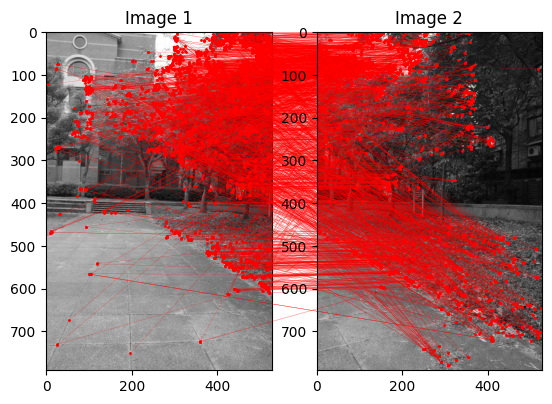

In [7]:
# 0 1 2 3 4 
# 从2开始match
# 2和3
pix_1_1,pix_1_2 = local_match(libary_corners[2],libary_corners[3],libary_features[2],libary_features[3])
match_visualizer(libary[2],libary[3],pix_1_1,pix_1_2)

1
40
266


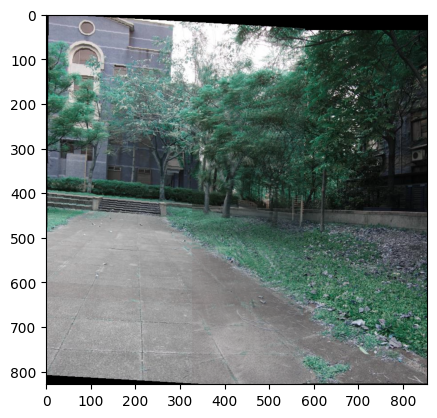

In [8]:
blend_1_ori = stitch_blend(libary_ori[2],libary_ori[3],align_pair(pix_1_1,pix_1_2))
plt.imshow(blend_1_ori)

C:\Users\远垂\AppData\Local\Temp\ipykernel_10556\2657793243.py:162: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(pix_1[i][1],pix_1[i][0],'ro',markersize=1,color='red')
C:\Users\远垂\AppData\Local\Temp\ipykernel_10556\2657793243.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(pix_2[i][1],pix_2[i][0],'ro',markersize=1,color='red')


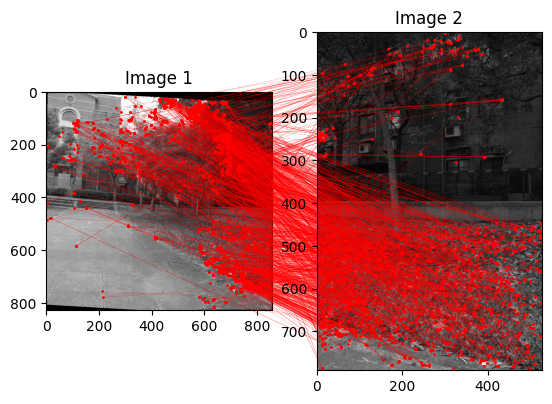

In [9]:
#23 和4
blend_1 = rgb_to_gray(blend_1_ori)
blend_1_corners = corner_selection(harris_response(blend_1,0.05,3),0.01,3)
blend_1_features = histogram_of_gradients(blend_1,blend_1_corners)
pix_2_1,pix_2_2 = local_match(blend_1_corners,libary_corners[4],blend_1_features,libary_features[4])
match_visualizer(blend_1,libary[4],pix_2_1,pix_2_2)

1
4
5
11
13
17
239


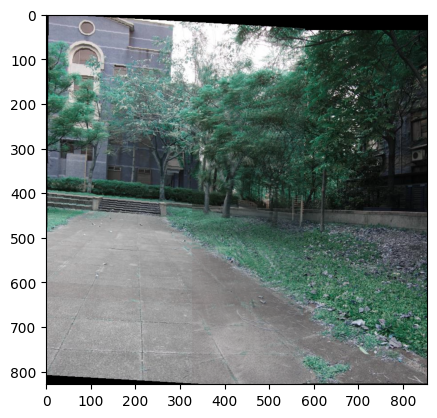

In [13]:
blend_2_ori = stitch_blend(blend_1_ori,libary_ori[4],align_pair(pix_2_1,pix_2_2))
plt.imshow(blend_1_ori)